In [76]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [77]:
df = pd.read_csv("heart_attack.csv")
df.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168189,Average,0,0,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.813242,Unhealthy,1,0,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.078353,Healthy,1,1,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.828130,Average,1,0,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804299,Unhealthy,1,0,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


# Initial Setup

In this classification, I will try to use PCA to see which features need selection but before that the data needs to be scaled.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [79]:
df_num = df.select_dtypes(np.number)
df_num.columns

Index(['Age', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day',
       'Heart Attack Risk'],
      dtype='object')

I will also be selecting 2 categorical columns like 'Sex' and 'Diet' to add to this

In [80]:
df_sex = df[['Sex']]
df_sex = pd.get_dummies(df_sex,drop_first=True,dtype=np.int8)
df_sex

,Sex_Male
0,1
1,1
2,0
3,1
4,1
...,...
8758,1
8759,0
8760,1
8761,1


In [81]:
df.Diet.value_counts()

Diet
Healthy      2960
Average      2912
Unhealthy    2891
Name: count, dtype: int64

In [82]:
def encode_diet(x):
    if x == 'Healthy':
        return 0
    elif x == 'Average':
        return 1
    else:
        return 2

df['Bad_Diet'] = df['Diet'].apply(lambda x: encode_diet(x))
df.head()

,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk,Bad_Diet
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,0,4.168189,Average,0,0,9,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0,1
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,1,1.813242,Unhealthy,1,0,1,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0,2
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,0,2.078353,Healthy,1,1,9,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,1,9.828130,Average,1,0,9,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0,1
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,0,5.804299,Unhealthy,1,0,6,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0,2


Now we concatenate them together

In [83]:
df2 = pd.concat([df_num,df_sex,df.Bad_Diet],axis = 1)
df3 = df2.drop(['Heart Attack Risk'],axis = 1)

In [84]:
Y = df['Heart Attack Risk']

# PCA

In [85]:
sc = StandardScaler()

In [86]:
scaled_df= sc.fit_transform(df3);
df4 = pd.DataFrame(scaled_df,index=df3.index,columns=df3.columns)
df4.head()

,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Sex_Male,Bad_Diet
0,0.625557,-0.641579,-0.147042,-1.369651,-0.986061,0.339157,-1.002857,-1.219867,-1.010838,-0.991704,-0.996696,1.234604,0.179251,1.280130,0.373454,-0.588539,-1.528843,-0.514750,0.658765,0.009637
1,-1.539322,1.596895,1.118179,0.730113,1.014136,0.339157,0.997151,0.819762,-1.418027,1.008365,-0.996696,-1.563129,-0.297225,1.582523,-0.268479,-0.816487,-1.090738,-0.011823,0.658765,1.233496
2,-1.539322,0.793023,-0.147042,0.730113,-0.986061,-2.948488,-1.002857,-1.219867,-1.372188,1.008365,1.003315,1.234604,1.001031,0.955917,-0.113134,0.756800,0.223577,-1.520604,-1.517992,-1.214223
3,1.425621,1.522691,-0.098380,0.730113,1.014136,0.339157,-1.002857,0.819762,-0.032188,1.008365,-0.996696,1.234604,0.477557,-0.404902,1.198524,-0.177339,-0.214528,-1.520604,0.658765,0.009637
4,0.578495,0.718820,0.874867,0.730113,1.014136,0.339157,0.997151,-1.219867,-0.727941,1.008365,-0.996696,0.185454,-1.292170,0.028445,-1.120826,-0.834365,-1.090738,-1.017677,0.658765,1.233496


Now we can see that each one has a mean at 0 and standard deviation of 1

In [87]:
df4.describe()

,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Sex_Male,Bad_Diet
count,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03,8.763000e+03
mean,-5.756994e-17,5.594825e-17,1.763586e-16,-5.331300e-17,-9.152403e-17,1.465601e-16,9.121997e-17,1.392625e-16,1.232483e-16,4.601541e-17,1.402760e-16,-6.324584e-17,-2.756870e-17,1.652095e-16,-3.462305e-16,-5.716451e-17,-2.594701e-17,-1.824399e-16,-5.270487e-18,-3.466359e-17
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-1.680510e+00,-1.729898e+00,-1.704237e+00,-1.369651e+00,-9.860609e-01,-2.948488e+00,-1.002857e+00,-1.219867e+00,-1.731130e+00,-9.917039e-01,-9.966961e-01,-1.563129e+00,-1.728837e+00,-1.715281e+00,-1.723282e+00,-1.732748e+00,-1.528843e+00,-1.520604e+00,-1.517992e+00,-1.214223e+00
25%,-8.804460e-01,-8.394550e-01,-8.769771e-01,-1.369651e+00,-9.860609e-01,3.391568e-01,-1.002857e+00,-1.219867e+00,-8.701960e-01,-9.917039e-01,-9.966961e-01,-8.636957e-01,-8.640384e-01,-8.682223e-01,-8.654242e-01,-8.589480e-01,-6.526332e-01,-1.017677e+00,-1.517992e+00,-1.214223e+00
50%,1.374337e-02,-1.084870e-02,-1.055100e-03,7.301131e-01,-9.860609e-01,3.391568e-01,9.971512e-01,8.197616e-01,9.557563e-03,-9.917039e-01,-9.966961e-01,-1.642626e-01,-1.732987e-02,-4.929614e-03,-1.937807e-02,-3.026125e-03,-2.145280e-01,-1.182278e-02,6.587652e-01,9.636688e-03
75%,8.608701e-01,8.672267e-01,8.748669e-01,7.301131e-01,1.014136e+00,3.391568e-01,9.971512e-01,8.197616e-01,8.707198e-01,1.008365e+00,1.003315e+00,8.848870e-01,8.728487e-01,8.624216e-01,8.598357e-01,8.685392e-01,6.616823e-01,9.940317e-01,6.587652e-01,1.233496e+00
max,1.707997e+00,1.732935e+00,1.702127e+00,7.301131e-01,1.014136e+00,3.391568e-01,9.971512e-01,8.197616e-01,1.726389e+00,1.008365e+00,1.003315e+00,1.584320e+00,1.732644e+00,1.758592e+00,1.757569e+00,1.708818e+00,1.537893e+00,1.496959e+00,6.587652e-01,1.233496e+00


In [88]:
df4.shape

(8763, 20)

Out of 20 columns, I'm going to be selecting 10

In [89]:
pca = PCA(n_components=10)  #3 components
principalComponents = pca.fit_transform(df4)

In [90]:
df5 = pd.DataFrame(principalComponents,columns = [f"PCA-{i}" for i in range(10)])

In [91]:
df5.head()

,PCA-0,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9
0,-0.890037,0.875890,0.863473,0.550911,-0.108545,0.503163,1.790763,0.435860,1.168839,2.217847
1,0.005228,-0.656692,0.460290,-1.254933,0.319385,-1.225495,2.034972,0.166361,-0.950530,-1.121955
2,3.566643,0.569731,0.862110,-1.057025,-1.292895,1.637963,1.109982,0.692553,0.733133,-0.585999
3,-1.327152,-0.014597,-0.845785,-0.344110,-1.374422,0.275179,-0.996315,0.978842,1.195813,-0.650052
4,-0.841630,1.003123,0.360524,-0.121210,1.184683,0.113375,0.380633,-0.102742,-0.687842,-0.028876


# Decision Tree Classifier

Now we split the data into our train and test set

In [92]:
x_train, x_test, y_train, y_test = train_test_split(df5, Y, test_size=0.3, random_state=999)

In [93]:
dt = DecisionTreeClassifier()

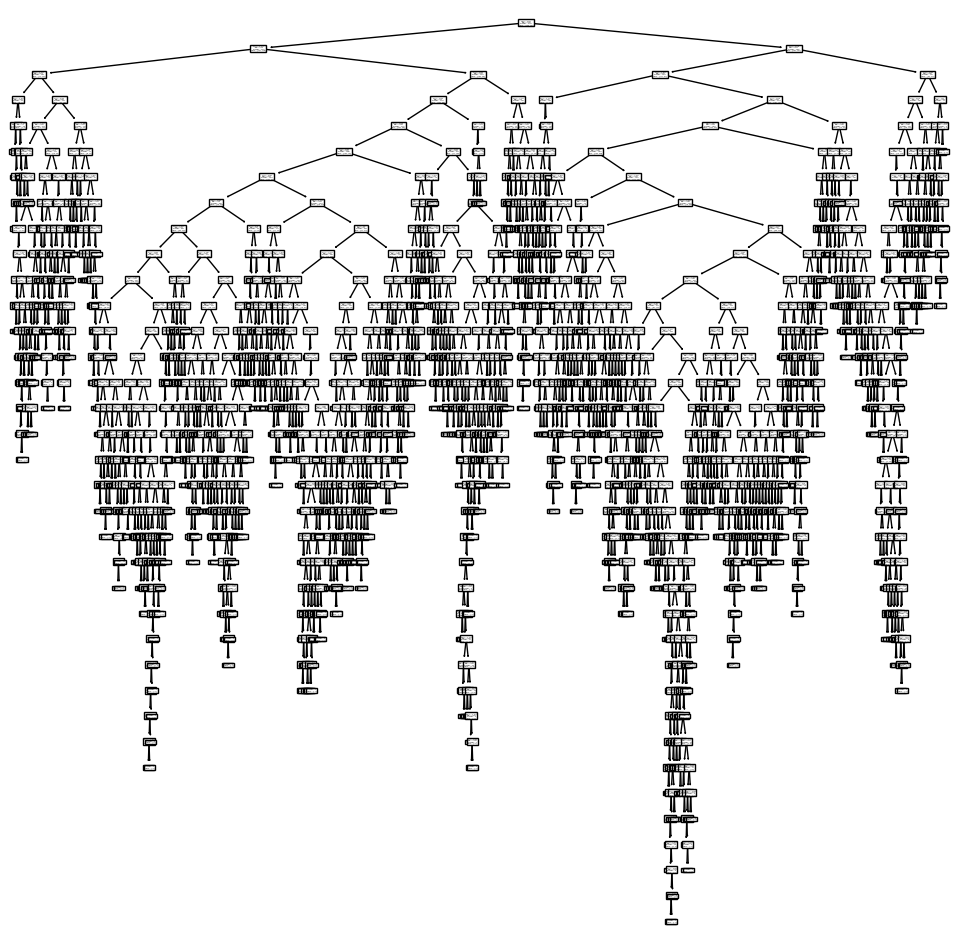

In [94]:
dt.fit(x_train, y_train)
plt.figure(figsize=(12,12))
_ = plot_tree(dt) # can read about Gini here: en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity

We can see that the Decision tree is too big, and might result in overfitting

In [95]:
dt.score(x_train, y_train)

1.0

In [96]:
dt.score(x_test, y_test)

0.5378470901483454

Which it has

# Hyperparameter Tuning

To optimize the model further, we will change some of its parameters to hopefully attain a better result.

In [97]:
params = {"max_depth" : [3,5,7,9,11],
          "criterion" : ["gini", "entropy", "log_loss"],
          "min_samples_split" : [2,4,6,8]
         }

In [98]:
tuned_model = GridSearchCV(dt,params,verbose=0,cv=5,return_train_score=False)
tuned_model.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 9, 11],
                         'min_samples_split': [2, 4, 6, 8]})

In [99]:
tuned_model = GridSearchCV(dt,params,verbose=0,cv=5,return_train_score=False)
tuned_model.score(x_train,y_train)

0.6416693837626345

In [100]:
tuned_model.score(x_test,y_test)

0.6405477367820464

In [101]:
tuned_model.best_params_

{'criterion': 'log_loss', 'max_depth': 3, 'min_samples_split': 4}

These were the parameters used in the final model. The accuracy isn't the best, but its better than the overfitting model we had before.